# Ion channel dynamics

### Modelling ion channels as Markov chains

Let's consider the simple scenario depicted in the following picture: a ion channel that can be in one of two states, _open_ or _closed_, with transition rates given by the __constant__ values $\alpha$ and $\beta$, which have units of [1/ms].

<img src="markov_model_ion_channel.png" width="200px"/>

How long a channel stays in a given state is called its __occupancy lifetime__: this is a random variable described by an exponential distribution, i.e., the inter-event intervals follow a Poisson distribution.

For the case above, the PDFs are:

$
f_{T_c}(T) = \alpha \exp(-\alpha T) \\
f_{T_o}(T) = \beta \exp(-\beta T)
$

and the CDFs are:

$
F_{T_c}(T) = 1 - \exp(-\alpha T) \\
F_{T_o}(T) = 1 - \exp(-\beta T)
$

Therefore, the probability of observing a transition from C to O (or from O to C) in a (short) time $\Delta t$ is given by:

$
\mathrm{Prob}\left\{ C\rightarrow O \ \mathrm{in} \ [t;t+\Delta t)\right\} \simeq \alpha \Delta t \\
\mathrm{Prob}\left\{ O\rightarrow C \ \mathrm{in} \ [t;t+\Delta t)\right\} \simeq \beta \Delta t
$

where we have expanded the CDF using the Taylor series around the point $\Delta t$.

### A dynamical description

We are now interested in understanding how the probability of being in either of the two states evolves over time. For instance, the probability of being in the closed state at time $t+\Delta t$ is given by the probability of being in the closed state at time $t$ __and__ not moving to the open state __or__ being in the open state at time $t$ and moving to the closed state. This can be written as:

$P_C(t+\Delta t) = P_C(t)(1-\alpha \Delta t) + P_O\beta \Delta t$

Analogously for the probability of being in the open state we can write

$P_O(t+\Delta t) = P_O(t)(1-\beta \Delta t) + P_C\alpha \Delta t$

Taking the limit for $\Delta t\rightarrow 0$, we get the following system of linear differential equations:

$
\dot{P_C} = -\alpha P_C + \beta P_O \\
\dot{P_O} = \alpha P_C - \beta P_O,
$

which admits the following equilibrium point:

$
P_C = \frac{\beta}{\alpha+\beta} \\
P_O = \frac{\alpha}{\alpha+\beta}
$

### Relationship to the Hodgkin-Huxley model

The ODEs of the gating variables in HH-style models have the following form:

$\dot{x} = \alpha (1-x) - \beta x$,

where $x$ represents the __fraction__ of channels that are in the open state.

They can be equivalently written in the following form:

$\dot{x} = \frac{x_\infty - x}{\tau_x}$,

which has the advantage of explicitly indicating the steady-state value of the $x$ gating variable and the associated time constant.

Importantly, in HH-style neuron models, the rate functions depend on the value of the membrane voltage.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import expon
import matplotlib.pyplot as plt
import seaborn as sns
cmap = plt.get_cmap('Paired')

These are the rate functions of the HH model for the potassium conductance:

In [2]:
def vtrap(x,y):
    if np.isscalar(x):
        return y*(1-x/y/2) if abs(x/y)<1e-6 else x/(np.exp(x/y) - 1)
    z = np.zeros_like(x, dtype=float)
    idx = abs(x/y) < 1e-6
    z[idx] = y*(1-x[idx]/y/2)
    np.logical_not(idx, out=idx)
    z[idx] = x[idx]/(np.exp(x[idx]/y) - 1)
    return z

alphan = lambda v: 0.01 * vtrap(-(v+55), 10)
betan  = lambda v: 0.125 * np.exp(-(v+65)/80)
alpham = lambda v: 0.1 * vtrap(-(v+40), 10)
betam  = lambda v: 4 * np.exp(-(v+65)/18)
alphah = lambda v: 0.07 * np.exp(-(v+65)/20)
betah  = lambda v: 1 / (1 + np.exp(-(v+35)/10))

Let's see how they depend on time:

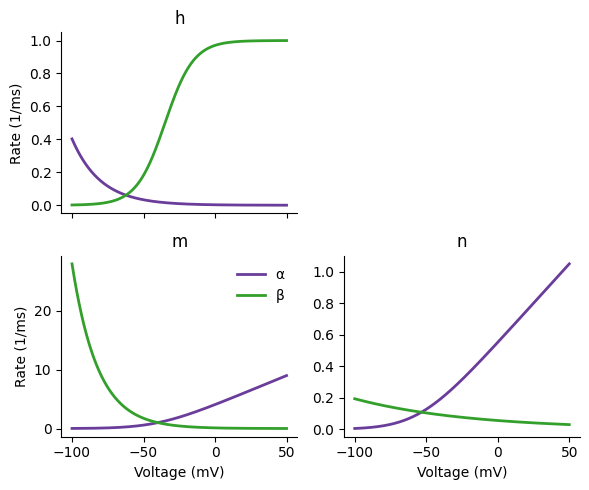

In [3]:
v = np.r_[-100 : 50 : 0.1]
fig,ax = plt.subplots(2, 2, figsize=(6,5), sharex=True)


α,β = alphah(v), betah(v)
ax[0,0].plot(v, α, color=cmap(9), lw=2, label='α')
ax[0,0].plot(v, β, color=cmap(3), lw=2, label='β')
ax[0,0].set_title('h')

α,β = alpham(v), betam(v)
ax[1,0].plot(v, α, color=cmap(9), lw=2, label='α')
ax[1,0].plot(v, β, color=cmap(3), lw=2, label='β')
ax[1,0].set_title('m')

α,β = alphan(v), betan(v)
ax[1,1].plot(v, α, color=cmap(9), lw=2, label='α')
ax[1,1].plot(v, β, color=cmap(3), lw=2, label='β')
ax[1,1].set_title('n')

ax[0,1].set_visible(False)

for a in ax[:,0]:
    a.set_ylabel('Rate (1/ms)')
for a in ax[-1,:]:
    a.set_xlabel('Voltage (mV)')

ax[1,0].legend(loc='upper right', frameon=False)
sns.despine()
fig.tight_layout()

Let's now plot the occupancy duration of the potassium channels for two values of $V_m$:

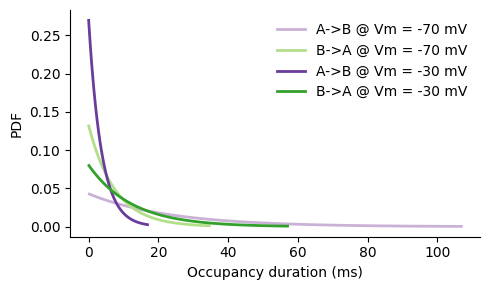

In [4]:
def expon_pdf(λ, n_points=100):
    rv = expon(scale=1/λ)
    x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), n_points)
    return x,rv.pdf(x)

Vm = np.array([-70, -30])
fig,ax = plt.subplots(1, 1, figsize=(5,3))
for i,v in enumerate(Vm):
    α,β = alphan(v), betan(v)
    x,y = expon_pdf(α)
    ax.plot(x, y, color=cmap(8+i), lw=2, label='A->B @ Vm = {:.0f} mV'.format(v))
    x,y = expon_pdf(β)
    ax.plot(x, y, color=cmap(2+i), lw=2, label='B->A @ Vm = {:.0f} mV'.format(v))
ax.set_xlabel('Occupancy duration (ms)')
ax.set_ylabel('PDF')
ax.legend(loc='upper right', frameon=False)
sns.despine()
fig.tight_layout()

Let's now simulate a population of ion channels and see how its dynamics compare to the solution of the linear system of ODEs derived above.

In [5]:
N_channels = 1000
dt   =   0.05 # [ms]
tend = 100    # [ms]
t = np.r_[0 : tend : dt]
n_steps = t.size
v = np.zeros_like(t)
v[t < tend/2] = Vm[0]
v[t >= tend/2] = Vm[1]
N_open = np.zeros_like(t, dtype=int)
N_open[0] = N_channels//2
P = np.zeros((2,n_steps))
P[:,0] = 0.5
I = np.eye(2)
α,β = alphan(v[0]), betan(v[0])
P[:,0] = np.array([β/(α+β), α/(α+β)])
N_open[0] = N_channels*P[1,0]
for i in range(n_steps-1):
    α,β = alphan(v[i]), betan(v[i])
    p_open,p_close = α*dt, β*dt
    rnd = np.random.uniform(size=N_channels-N_open[i])
    opening = np.sum(rnd < p_open)
    rnd = np.random.uniform(size=N_open[i])
    closing = np.sum(rnd < p_close)
    N_open[i+1] = N_open[i] + opening - closing
    Q = np.array([[-α,β],[α,-β]])
    P[:,i+1] = (I + dt*Q) @ P[:,i]

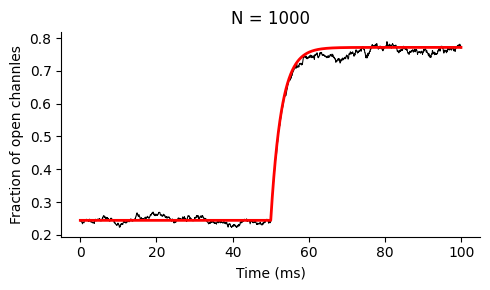

In [6]:
fig,ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(t, N_open/N_channels, 'k', lw=0.75)
ax.plot(t, P[1], 'r', lw=2)
ax.set_title(f'N = {N_channels}')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Fraction of open channles')
sns.despine()
fig.tight_layout()